In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow==2.9.1

ERROR: Could not find a version that satisfies the requirement tensorflow==2.9.1 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.9.1


In [ ]:
import os
import re
import requests
from PIL import Image
import pandas as pd
import numpy as np

#libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# import Deep learning Libraries
#preprocessing, modeling & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings('ignore')

In [ ]:
base_path = '/content/drive/MyDrive/colondata/colon_image_sets'
categories = ["colon_aca","colon_n"]

In [ ]:
image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(base_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_paths.append(image_path)
        labels.append(category)

df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})

In [ ]:
df.head()

,image_path,label
0,/content/drive/MyDrive/colondata/colon_image_s...,colon_aca
1,/content/drive/MyDrive/colondata/colon_image_s...,colon_aca
2,/content/drive/MyDrive/colondata/colon_image_s...,colon_aca
3,/content/drive/MyDrive/colondata/colon_image_s...,colon_aca
4,/content/drive/MyDrive/colondata/colon_image_s...,colon_aca


In [ ]:
df.tail()

,image_path,label
9995,/content/drive/MyDrive/colondata/colon_image_s...,colon_n
9996,/content/drive/MyDrive/colondata/colon_image_s...,colon_n
9997,/content/drive/MyDrive/colondata/colon_image_s...,colon_n
9998,/content/drive/MyDrive/colondata/colon_image_s...,colon_n
9999,/content/drive/MyDrive/colondata/colon_image_s...,colon_n


In [ ]:
df.shape

(10000, 2)

In [ ]:
df.columns

Index(['image_path', 'label'], dtype='object')

In [ ]:
df.isnull().sum()

,0
image_path,0
label,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  10000 non-null  object
 1   label       10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [ ]:
df['label'].unique()

array(['colon_aca', 'colon_n'], dtype=object)

In [ ]:
df['label'].value_counts()

,count
label,
colon_aca,5000
colon_n,5000


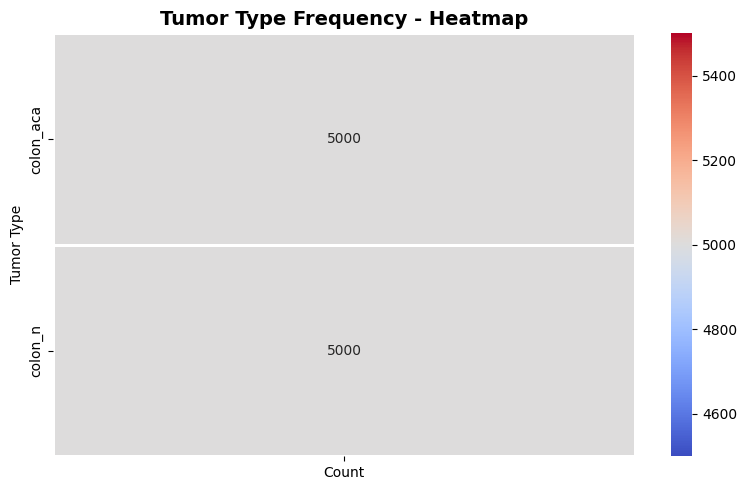

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

fig = px.treemap(df, path=["label"], title="Tumor Types - Treemap",
                 color_discrete_sequence=px.colors.qualitative.T10_r)
fig.update_traces(textinfo="label+percent entry")
fig.show()

label_counts_df = df['label'].value_counts().reset_index()
label_counts_df.columns = ['Tumor Type', 'Count']

# Pivot to a 1-row heatmap-friendly format
heatmap_data = label_counts_df.pivot_table(index='Tumor Type', values='Count')

# Convert 'Count' column to integers before plotting
heatmap_data['Count'] = heatmap_data['Count'].astype(int)  # Convert to integers

plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt='d', linewidths=1, linecolor='white')

plt.title("Tumor Type Frequency - Heatmap", fontsize=14, fontweight='bold')
plt.xlabel("")
plt.ylabel("Tumor Type")
plt.tight_layout()
plt.show()

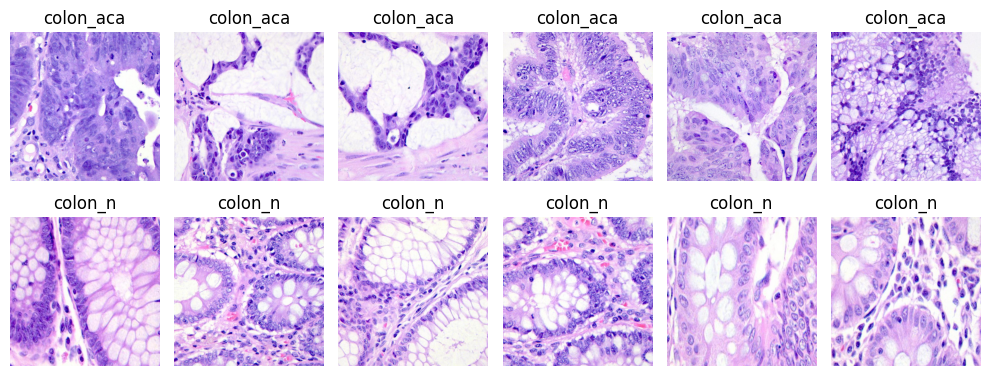

In [ ]:

import cv2

num_images = 6

plt.figure(figsize=(10 , 4))

for i, category in enumerate(categories):
    category_images = df[df['label'] == category]['image_path'].iloc[:num_images]

    for j, img_path in enumerate(category_images):

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(categories), num_images, i * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['category_encoded'] = label_encoder.fit_transform(df['label'])

In [ ]:
df = df[['image_path', 'category_encoded']]

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['image_path']], df['category_encoded'])

In [ ]:
df_resampled = pd.DataFrame(X_resampled, columns=['image_path'])
df_resampled['category_encoded'] = y_resampled


In [ ]:
print("\nClass distribution after oversampling:")
print(df_resampled['category_encoded'].value_counts())


Class distribution after oversampling:
category_encoded
0    5000
1    5000
Name: count, dtype: int64


In [ ]:
df_resampled

,image_path,category_encoded
0,/content/drive/MyDrive/colondata/colon_image_s...,0
1,/content/drive/MyDrive/colondata/colon_image_s...,0
2,/content/drive/MyDrive/colondata/colon_image_s...,0
3,/content/drive/MyDrive/colondata/colon_image_s...,0
4,/content/drive/MyDrive/colondata/colon_image_s...,0
...,...,...
9995,/content/drive/MyDrive/colondata/colon_image_s...,1
9996,/content/drive/MyDrive/colondata/colon_image_s...,1
9997,/content/drive/MyDrive/colondata/colon_image_s...,1
9998,/content/drive/MyDrive/colondata/colon_image_s...,1


In [ ]:
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(str)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")


In [ ]:
  train_df_new, temp_df_new = train_test_split(
      df_resampled,
      train_size=0.8,
      shuffle=True,
      random_state=42,
      stratify=df_resampled['category_encoded']
  )

  valid_df_new, test_df_new = train_test_split(
      temp_df_new,
      test_size=0.5,
      shuffle=True,
      random_state=42,
      stratify=temp_df_new['category_encoded']
  )

In [ ]:
batch_size = 16
img_size = (256, 256)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)


Found 8000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Multiply, Reshape, BatchNormalization, Activation
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is set for TensorFlow")
    except RuntimeError as e:
        print(e)

GPU is set for TensorFlow


In [ ]:
from tensorflow.keras.layers import Add

In [ ]:
from tensorflow.keras.layers import Add, GlobalAveragePooling2D, Dense, BatchNormalization, Reshape, Multiply, Input, UpSampling2D

In [ ]:
from tensorflow.keras.layers import Add, GlobalAveragePooling2D, Dense, BatchNormalization, Reshape, Multiply, Input, Conv2D, UpSampling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

def attention_block(inputs, filters):
    x = GlobalAveragePooling2D()(inputs)
    x = Dense(filters // 16, activation='relu')(x)
    x = Dense(filters, activation='sigmoid')(x)
    x = Reshape((1, 1, filters))(x)
    return Multiply()([inputs, x])

def build_mranet(input_shape=(256, 256, 3), num_classes=2):
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

    conv4_block6_out = base_model.get_layer('conv4_block6_out').output
    conv5_block3_out = base_model.get_layer('conv5_block3_out').output

    attn_block1 = attention_block(conv4_block6_out, filters=1024)
    attn_block2 = attention_block(conv5_block3_out, filters=2048)

    attn_block2 = Conv2D(1024, (1, 1), padding='same', activation='relu')(attn_block2)

    attn_block2 = UpSampling2D((2, 2))(attn_block2)

    attn_block1_shape = K.int_shape(attn_block1)
    attn_block2_shape = K.int_shape(attn_block2)
    print("Shape of attn_block1:", attn_block1_shape)
    print("Shape of attn_block2:", attn_block2_shape)

    merged_attention = Add()([attn_block1, attn_block2])

    x = GlobalAveragePooling2D()(merged_attention)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=x)

    for layer in base_model.layers:
        layer.trainable = False

    return model

mranet_model = build_mranet()
mranet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

Shape of attn_block1: (None, 16, 16, 1024)
Shape of attn_block2: (None, 16, 16, 1024)


In [ ]:
from PIL import Image

def my_image_check(generator):
    while True:
        x, y = next(generator)
        new_x = []
        new_y = []
        for i in range(x.shape[0]):
            try:
                img = Image.fromarray((x[i] * 255).astype(np.uint8))
                img.verify()
                new_x.append(x[i])
                new_y.append(y[i])
            except Exception as e:
                print(f"Error loading image: {generator.dataframe['image_path'].iloc[generator.index + i] if (generator.index + i) < len(generator.dataframe) else 'Path information not available'}")
                print(f"Error: {e}")
        yield np.array(new_x), np.array(new_y)

tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_generator = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    stratify=df_resampled['category_encoded']
)
train_gen_new = my_image_check(train_generator)

valid_generator = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    stratify=df_resampled['category_encoded']
)

valid_gen_new = my_image_check(valid_generator)

test_generator = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size,
    stratify=df_resampled['category_encoded']
)

test_gen_new = my_image_check(test_generator)


steps_per_epoch = len(train_df_new) // batch_size
validation_steps = len(valid_df_new) // batch_size

Found 8000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [ ]:
history = mranet_model.fit(
    train_gen_new,
    epochs=100,
    validation_data=valid_gen_new,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
)

Epoch 1/100
  7/500 ━━━━━━━━━━━━━━━━━━━━ 1:12:12 9s/step - accuracy: 0.4448 - loss: 0.7904

KeyboardInterrupt: 

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_history_interactive(history):
    val_acc = history.history['val_accuracy']
    train_acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    train_loss = history.history['loss']
    epochs = list(range(1, len(train_acc) + 1))

    max_val_acc = max(val_acc)
    max_val_acc_epoch = val_acc.index(max_val_acc) + 1  # Epochs start from 1

    fig = make_subplots(rows=1, cols=2, subplot_titles=("Model Accuracy", "Model Loss"))

    # Accuracy plot
    fig.add_trace(go.Scatter(x=epochs, y=train_acc, mode='lines+markers', name='Train Accuracy'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=val_acc, mode='lines+markers', name='Validation Accuracy'), row=1, col=1)
    fig.add_trace(go.Scatter(
        x=[max_val_acc_epoch],
        y=[max_val_acc],
        mode='markers+text',
        text=[f"Max Val Acc: {max_val_acc:.2f}"],
        textposition='top center',
        marker=dict(color='red', size=10),
        name='Max Val Accuracy'),
        row=1, col=1
    )

    # Loss plot
    fig.add_trace(go.Scatter(x=epochs, y=train_loss, mode='lines+markers', name='Train Loss'), row=1, col=2)
    fig.add_trace(go.Scatter(x=epochs, y=val_loss, mode='lines+markers', name='Validation Loss'), row=1, col=2)

    fig.update_layout(
        title="Training History",
        xaxis_title="Epoch",
        yaxis_title="Metric Value",
        showlegend=True,
        template="plotly_white"
    )

    fig.show()

# Usage
plot_history_interactive(history)


63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step


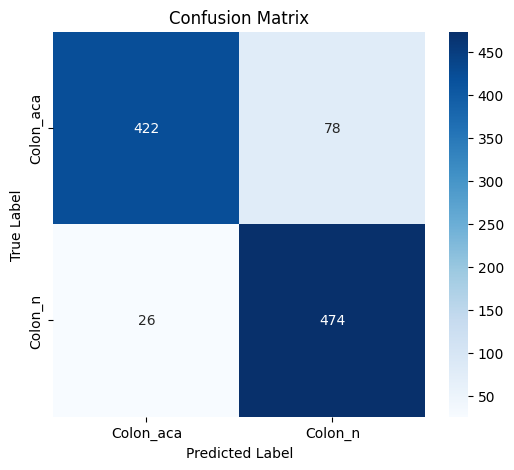

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.84      0.89       500
           1       0.86      0.95      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_true = test_generator.classes
y_pred = mranet_model.predict(test_generator)
y_pred_classes = np.round(y_pred).astype(int)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Colon_aca', 'Colon_n'], yticklabels=['Colon_aca', 'Colon_n'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n", classification_report(y_true, y_pred_classes))

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step


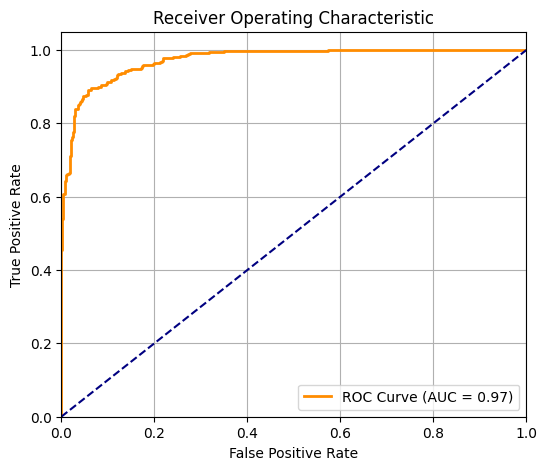

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get the true labels and predicted probabilities
y_true = test_generator.classes
y_pred_prob = mranet_model.predict(test_generator).ravel()  # flatten if shape is (n,1)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
